In [1]:
# !pip install hmmlearn
from hmmlearn.hmm import GaussianHMM

100%|██████████| 50/50 [01:13<00:00,  1.47s/it]


worst baseline HMM 1.8807893025903286
current baseline HMM 10.169102729397107
Baseline HMM: 1.8807893025903286
Running time of KF: 74.03159379959106
worst baseline KF 1.8807893025903286
current baseline KF 1.8807893025903286
Running time of KF: 0.006162166595458984


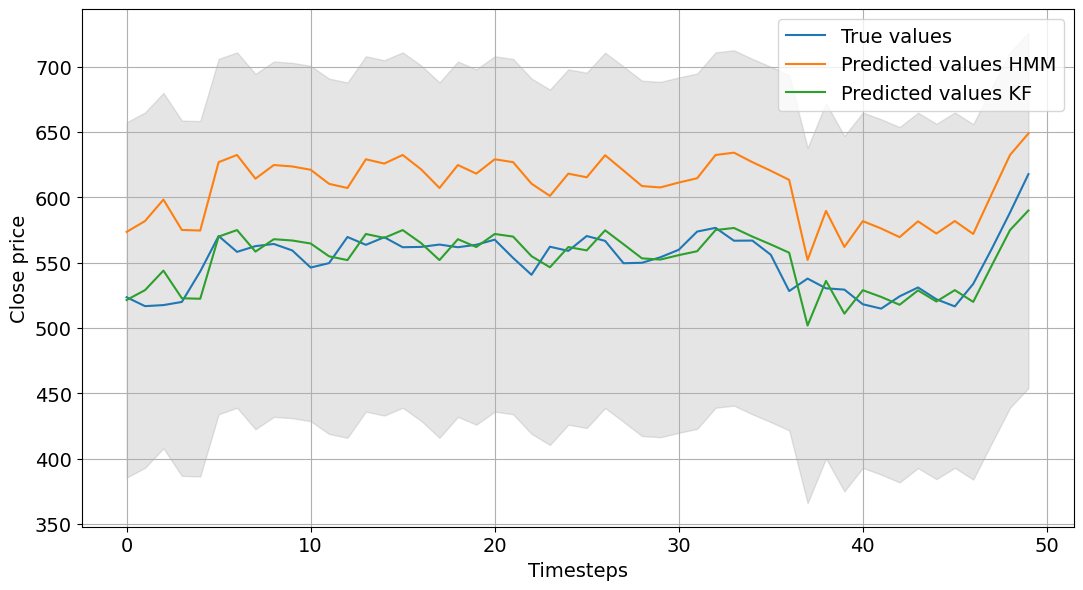

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import itertools
from tqdm import tqdm
import time
from scipy.special import logsumexp
plt.rcParams.update({'font.size': 14})

## load the data and split them to train and test
data = pd.read_csv("ADANIPOWER.NS.csv")

# We omit the dates, adjusted close and the volume columns. And we take only the data for 2018 and 2019
data = data.values[-100:,:-2]

# We train on 2018 data and we consider only open and high price
train = data[:-50, 1:5]

# We test on 2019 data
test = data[-50:, 1:5]

# We train on 2018 data and we consider only open and high price
train_X = train[:,0]
train_Y = train[:,3]
# We test on 2019 data
test_X = test[:,0]
test_Y = test[:,3]


def transform_train_data(data):
        # frac_change = (close - open) / open
        frac_change = (data[:,3] - data[:,0]) / data[:,0]

        # frac_high = (high - open) / open
        frac_high = (data[:,1] - data[:,0]) / data[:,0]

        # frac_low = (open - low) / open
        frac_low = (data[:,0] - data[:,2]) / data[:,0]

        return np.vstack((frac_change, frac_high, frac_low)).T

## train the model
class HMM_model():
    def __init__(self, n_components):
        self.model = GaussianHMM(n_components=n_components, algorithm='map', covariance_type='diag')

    def transform_data(self, data):

        log_data = np.zeros_like(data)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                log_data[i, j] = np.log(data[i, j])
    # frac_change = (close - open) / open
        frac_change = (log_data[:, 3] + 1e-10) / (log_data[:, 0] + 1e-10)

    # frac_high = (high - open) / open
        frac_high = (log_data[:, 1] + 1e-10) / (log_data[:, 0] + 1e-10)

    # frac_low = (open - low) / open
        frac_low = (log_data[:, 0] + 1e-10) / (log_data[:, 2] + 1e-10)

        return np.vstack((frac_change, frac_high, frac_low)).T


    def fit(self, train_data, sequence_len=-1):
        train_preprocessed = self.transform_data(train_data)
        if sequence_len != -1:
            lengths = divide_to_seq(train_preprocessed, sequence_len)
            self.model.fit(train_preprocessed, lengths)
        else:
            self.model.fit(train_preprocessed)

    def compute_predecessors(self, train, test, test_case_indice, latency):
        if test_case_indice == 0:
            predecessors = train[-latency:]
            return predecessors
        elif test_case_indice < latency:
            predecessors = np.concatenate((train[- latency + test_case_indice:], test[:test_case_indice]), axis=0)
            return predecessors
        elif test_case_indice >= latency:
            predecessors = test[test_case_indice - latency : test_case_indice]
            return predecessors

    def predict_for_one(self, predecessors, combinations):
        scores = []
        # compute the scores using the MAP
        for elt in combinations:
            elt_to_score = np.concatenate((predecessors, elt.reshape(-1,3)), axis=0)
            score = self.model.score(elt_to_score)
            scores.append(score)
        # returning the argmax
        scores = np.array(scores)
        return combinations[np.argmax(scores)]

    def predict(self, train_data, test_data, latency):
        # span the possible values
        frac_change_space = np.linspace(-0.1, 0.1, 50)
        frac_high_space = np.linspace(0, 0.1, 10)
        frac_low_space = np.linspace(0, 0.1, 10)

        # all possible combinations
        combinations = np.array(list(itertools.product(*[frac_change_space, frac_high_space, frac_low_space])))

        # transform the old train and test to get the new features
        train_data_preprocessed = self.transform_data(train_data)
        test_data_preprocessed = self.transform_data(test_data)

        predictions = []
        l = len(test_data_preprocessed)
        for i in tqdm(range(l)):
            predecessors = self.compute_predecessors(train_data_preprocessed, test_data_preprocessed, i, latency=latency)
            pred = self.predict_for_one(predecessors, combinations)
            predictions.append(pred)

        predictions = np.vstack(predictions)

        return predictions

def divide_to_seq(data, len_):
    n = int(len(data)/len_)
    lengths = []

    for i in range(n):
        elt = data[i*len_: i*len_+len_]
        lengths.append(len(elt))

    if n*len_ != len(data):
        elt = data[n*len_:]
        lengths.append(len(elt))

    return lengths

## test the model
def test_model_make_plots(train, test, n_components=5, latency=10, sequence_len=-1):
    since = time.time()

    model = HMM_model(n_components)
    model.fit(train, sequence_len)
    predictions = model.predict(train, test, latency=latency)

    time_elapsed = time.time() - since

    predicted_close = predictions[:,0] * test[:, 0] + test[:, 0]

    plt.figure(figsize=(6.4*2, 4.8*1.4))
    plt.plot(np.arange(len(test[:50])), test[:50, 3])
    plt.plot(np.arange(len(predicted_close[:50])), predicted_close[:50])
    '''plt.legend(['True values', 'Predicted values'])
    plt.xlabel('Timesteps')
    plt.ylabel('Close price')
    plt.grid()'''

    # we define the worst baseline as the opening price, if you can't do better you are better off predicting this price
    print('worst baseline HMM', np.mean(np.abs((test[:, 3] - test[:, 0]) / test[:, 3])) * 100)
    print('current baseline HMM', np.mean(np.abs((test[:, 3] - predicted_close) / test[:, 3])) * 100)
    # Calculate the baseline error for HMM
    baseline_hmm = np.mean(np.abs((test[:, 3] - test[:, 0]) / test[:, 3])) * 100
    print('Baseline HMM:', baseline_hmm)

    print('Running time of KF:', time_elapsed)



# Initialize arrays to store the prior mean (mu), the logarithm of the prior covariance (log_p), and the logarithm of the Kalman gain (log_k).
#Set the initial values for log_p and mu[0].
def pre_filtering(x, a, b, c, f):

  T = len(x)

#mu prior mean log_p prior covariance mean log_k kalman gain logarithm
  mu = np.zeros(shape=(T))
  log_p = np.zeros(shape=(T))
  log_k = np.zeros(shape=(T))
  log_p[0] = 10000
  mu[0] = x[0]

#T corresponds to the number of time steps or observations for which the filter is applied.
#It represents the length of the time series data over which the Kalman filter iterates to estimate the state of the system at each time step.
  # example we start by \mu_{1|0} and \p_{1|0} assuming we have x = (x_1, x_2,..., x_N) a vector of N elements
  for t in range(1,T):
    mu[t] = a + b*mu[t-1]    #Update Prior Mean (mu[t]): Update the prior mean at time step t using the dynamic model.
    log_p[t] = logsumexp([np.log(b**2) + log_p[t-1], np.log(c**2)])  #Update Logarithm of Prior Covariance (log_p[t]): Update the logarithm of the prior covariance at time step t based on the dynamic model parameters b and measurement noise c.
    log_k[t] = log_p[t-1] - logsumexp([log_p[t-1], np.log(f**2)])   # updating kaldman gain
  return mu, log_p, log_k

def filtering(x, y, a, b, c, f):
  T = len(y)
  mu, log_p, log_k = pre_filtering(x, a, b, c, f)  #callinf pre filtering function to get prior mean and covariance

  mu_filt = np.zeros(shape=(T))  # initialise to store filtered mean
  p_filt = np.zeros(shape=(T))   #initialise array to store covariance filtered

  for t in range(T):
    mu_filt[t] = mu[t] + np.exp(log_k[t])*(y[t] - mu[t])  #update filtered mean at t time using  pre-filtered mean, Kalman gain, and observation.
    p_filt[t] = (f**2) * np.exp(log_k[t])  #Update the filtered covariance at time step t using the pre-filtered covariance and the measurement noise.

  return mu_filt, p_filt


  #The Kalman gain is computed based on the predicted covariance and the measurement noise.
  #It represents the trade-off between the predicted state and the observed measurement






# def pre_filtering(x, a, b, c, f):

#   T = len(x)

#   mu = np.zeros(shape=(T))
#   p = np.zeros(shape=(T))
#   k = np.zeros(shape=(T))
#   p[0] = 10000
#   mu[0] = x[0]

#   # example we start by \mu_{1|0} and \p_{1|0} assuming we have x = (x_1, x_2,..., x_N) a vector of N elements
#   for t in range(1,T):
#     mu[t] = a + b*mu[t-1]
#     p[t] = (b**2) * p[t-1] + c**2
#     k[t] = p[t] / (p[t] + f**2)

#   return mu, p, k

# def filtering(x, y, a, b, c, f):
#   T = len(y)
#   mu, p, k = pre_filtering(x, a, b, c, f)

#   mu_filt = np.zeros(shape=(T))
#   p_filt = np.zeros(shape=(T))

#   for t in range(T):
#     mu_filt[t] = mu[t] + k[t]*(y[t] - mu[t])
#     p_filt[t] = (f**2) * k[t]

#   return mu_filt, p_filt

def initialize_params(x, y):
    T = len(y)

    x_t = x[1:]
    x_t_1 = x[:-1]

    f_2 = ((y - x)**2).sum() / len(y)
    b = ((T-1)*(x_t * x_t_1).sum() - x_t.sum() * x_t_1.sum())/((T-1)*((x_t_1**2).sum()) - x_t_1.sum()**2)
    a = (x_t - b*x_t_1).sum() / (T-1)
    c_2 = ((x_t - a - b*x_t_1)**2).sum() / (T-1)

    return a, b, c_2, f_2

test_model_make_plots(train, test, latency=10, sequence_len = -1)

x_train = train_Y
y_train = train_X
x_test = test_Y
y_test = test_X

since_kf = time.time()

a, b, c_2, f_2 = initialize_params(x_train, y_train)

mu_fore, p_fore = filtering(x_test, y_test, a, b, np.sqrt(c_2), np.sqrt(f_2))

time_elapsed_kf = time.time() - since_kf

plt.plot(np.arange(50), mu_fore[:50])
plt.fill_between(np.arange(50), mu_fore[:50] - p_fore[:50] / 2, mu_fore[:50] + p_fore[:50] / 2, color='gray', alpha=0.2)
plt.legend(['True values', 'Predicted values HMM', 'Predicted values KF'])
plt.xlabel('Timesteps')
plt.ylabel('Close price')
plt.grid()

print('worst baseline KF', np.mean(np.abs((x_test - test[:,0]) / x_test))* 100)
print('current baseline KF', np.mean(np.abs((x_test - mu_fore) / x_test))* 100)
print('Running time of KF:', time_elapsed_kf)

100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

worst baseline HMM 1.8807893025903286
current baseline HMM 10.169102729397107
Running time of HMM: 66.7747642993927


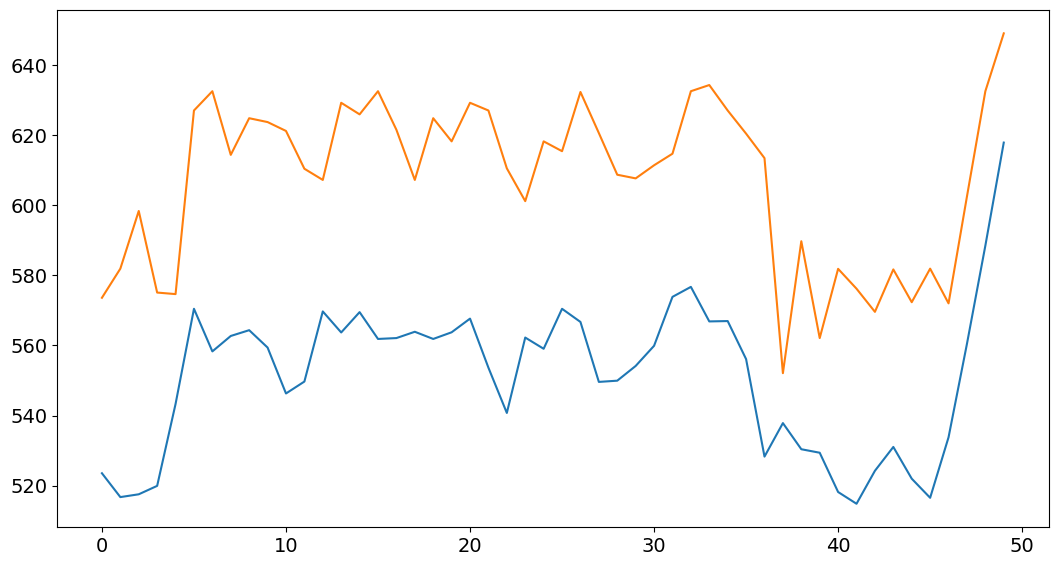

In [3]:
def test_model_make_plots(train, test, n_components=5, latency=10, sequence_len=-1):
    since = time.time()

    model = HMM_model(n_components)
    model.fit(train, sequence_len)
    predictions = model.predict(train, test, latency=latency)

    time_elapsed = time.time() - since

    predicted_close = predictions[:,0] * test[:, 0] + test[:, 0]

    plt.figure(figsize=(6.4*2, 4.8*1.4))
    plt.plot(np.arange(len(test[:50])), test[:50, 3])
    plt.plot(np.arange(len(predicted_close[:50])), predicted_close[:50])

    # we define the worst baseline as the opening price, if you can't do better you are better off predicting this price
    print('worst baseline HMM', np.mean(np.abs((test[:, 3] - test[:, 0]) / test[:, 3])) * 100)
    print('current baseline HMM', np.mean(np.abs((test[:, 3] - predicted_close) / test[:, 3])) * 100)
    print('Running time of HMM:', time_elapsed)

    return predictions  # return the predictions

# Call the function to get predictions
predictions = test_model_make_plots(train, test, latency=10, sequence_len=-1)


In [8]:
from sklearn.metrics import r2_score

def calculate_metrics(actual, predicted):
    metrics = {}
    # Calculate metrics here
    # Example metrics:
    metrics['Mean Absolute Error'] = np.mean(np.abs(actual - predicted))
    metrics['Root Mean Squared Error'] = np.sqrt(np.mean((actual - predicted) ** 2))
    metrics['R2 Score'] = r2_score(actual, predicted)
    return metrics

In [9]:
predicted_close = predictions[:,0] * test[:, 0] + test[:, 0]

# Calculate metrics for HMM and Kalman Filter
hmm_metrics = calculate_metrics(test[:, 3], predicted_close)
kf_metrics = calculate_metrics(x_test, mu_fore)

print("HMM Metrics:")
for metric, value in hmm_metrics.items():
    print(f"{metric}: {value}")

print("\nKalman Filter Metrics:")
for metric, value in kf_metrics.items():
    print(f"{metric}: {value}")

HMM Metrics:
Mean Absolute Error: 55.90010087599999
Root Mean Squared Error: 57.5811863113679
R2 Score: -6.268407056999886

Kalman Filter Metrics:
Mean Absolute Error: 10.337002520000004
Root Mean Squared Error: 13.101641773626417
R2 Score: 0.6237041172100886


In [17]:
# model Genration code 
def generate_model(train, test, n_components=5, latency=10, sequence_len=-1):
    since = time.time()

    model = HMM_model(n_components)
    model.fit(train, sequence_len)
    predictions = model.predict(train, test, latency=latency)

    time_elapsed = time.time() - since

    predicted_close = predictions[:,0] * test[:, 0] + test[:, 0]

    plt.figure(figsize=(6.4*2, 4.8*1.4))
    plt.plot(np.arange(len(test[:50])), test[:50, 3])
    plt.plot(np.arange(len(predicted_close[:50])), predicted_close[:50])

    # we define the worst baseline as the opening price, if you can't do better you are better off predicting this price
    print('worst baseline HMM', np.mean(np.abs((test[:, 3] - test[:, 0]) / test[:, 3])) * 100)
    print('current baseline HMM', np.mean(np.abs((test[:, 3] - predicted_close) / test[:, 3])) * 100)
    print('Running time of HMM:', time_elapsed)

    return predictions  # return the predictions

In [21]:
import pickle

hmm = generate_model(train, test, latency=10, sequence_len=-1)
with open('hmm.pkl', 'wb') as f:
    pickle.dump(hmm, f)
    


AttributeError: 'HMM_model' object has no attribute 'save'